In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dtypes ={
    'id': np.uint32,
    'qid1': np.uint32,
    'qid2': np.uint32,
    'question1': np.str,
    'question2': np.str,
    'is_duplicate': np.uint8
}

nlp = spacy.load('en_core_web_md')

df = pd.read_csv('../../dataset/quora_train.csv.zip', compression='zip', dtype=dtypes, nrows=110000)[10000:]
df.describe()

,id,qid1,qid2,is_duplicate
count,100000.000000,100000.000000,100000.000000,100000.00000
mean,59999.500000,89596.495130,89657.442620,0.37211
std,28867.657797,49598.160275,49756.845566,0.48337
min,10000.000000,4.000000,26.000000,0.00000
25%,34999.750000,46597.500000,46449.750000,0.00000
50%,59999.500000,86992.000000,86922.000000,0.00000
75%,84999.250000,131682.500000,132196.500000,1.00000
max,109999.000000,180438.000000,180439.000000,1.00000


In [2]:
def tokenize_qs(df):
    df['tn_q1'] = df['question1'].map(lambda x: nlp(str(x)))
    df['tn_q2'] = df['question2'].map(lambda x: nlp(str(x)))

tokenize_qs(df)

In [3]:
from tqdm import tqdm

co_noun_dic = dict()

for i, row in tqdm(df.iterrows()):
    if row['is_duplicate'] == 0:
        continue
    q1 = list(set([t.lemma for t in row['tn_q1'] if t.pos_.startswith('N')]))
    q2 = list(set([t.lemma for t in row['tn_q2'] if t.pos_.startswith('N')]))
    
    for t1 in q1:
        for t2 in q2:
            if t1 not in co_noun_dic:
                co_noun_dic[t1] = dict()
            if t2 not in co_noun_dic:
                co_noun_dic[t2] = dict()
            co_noun_dic[t1][t2] = min(co_noun_dic[t1][t2] + 1 if t2 in co_noun_dic[t1] else 1, 5)
            co_noun_dic[t2][t1] = min(co_noun_dic[t2][t1] + 1 if t1 in co_noun_dic[t2] else 1, 5)
            
co_verb_dic = dict()

for i, row in tqdm(df.iterrows()):
    if row['is_duplicate'] == 0:
        continue
    q1 = list(set([t.lemma for t in row['tn_q1'] if t.pos_.startswith('V')]))
    q2 = list(set([t.lemma for t in row['tn_q2'] if t.pos_.startswith('V')]))
    
    for t1 in q1:
        for t2 in q2:
            if t1 not in co_verb_dic:
                co_verb_dic[t1] = dict()
            if t2 not in co_verb_dic:
                co_verb_dic[t2] = dict()
            co_verb_dic[t1][t2] = min(co_verb_dic[t1][t2] + 1 if t2 in co_verb_dic[t1] else 1, 5)
            co_verb_dic[t2][t1] = min(co_verb_dic[t2][t1] + 1 if t1 in co_verb_dic[t2] else 1, 5)  

100000it [00:10, 9704.36it/s]
100000it [00:09, 10516.33it/s]


In [4]:
def add_len_diff(df):
    df['len_diff'] = df[['question1', 'question2']].apply(lambda x: abs(len(str(x[0])) - len(str(x[1]))), axis=1)
    df['len_diff_ratio'] = df[['question1', 'question2']].apply(lambda x: 1 - min(len(str(x[0])), len(str(x[1]))) / max(len(str(x[0])), len(str(x[1]))), axis=1)

In [5]:
def add_wordlen_diff(df):
    df['wordlen_diff_ratio'] = df[['question1', 'question2']].apply(lambda x: 1 - min(len(str(x[0]).split()), len(str(x[1]).split())) / max(len(str(x[0]).split()), len(str(x[1]).split())), axis=1)
    df['wordlen_diff'] = df[['question1', 'question2']].apply(lambda x: abs(len(str(x[0]).split()) - len(str(x[1]).split())), axis=1)

In [6]:
from itertools import starmap

def score_co_noun(ts1, ts2, co_noun_dic):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('N')]
    ts2 = [t for t in ts2 if t.pos_.startswith('N')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += co_noun_dic[t1.lemma][t2.lemma] if t1.lemma in co_noun_dic and t2.lemma in co_noun_dic[t1.lemma] else 0
            
    return score / (len(ts1) + len(ts2)) if not (len(ts1) + len(ts2)) == 0 else 0

def add_conoun_score(df):
    df['co_noun_score'] = list(starmap(lambda a, b: score_co_noun(a, b, co_noun_dic), zip(df['tn_q1'], df['tn_q2'])))

In [7]:
def score_co_verb(ts1, ts2, co_verb_dic):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('V')]
    ts2 = [t for t in ts2 if t.pos_.startswith('V')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += co_verb_dic[t1.lemma][t2.lemma] if t1.lemma in co_verb_dic and t2.lemma in co_verb_dic[t1.lemma] else 0
            
    return score / (len(ts1) + len(ts2)) if not (len(ts1) + len(ts2)) == 0 else 0

def add_coverb_score(df):
    df['co_verb_score'] = list(starmap(lambda a, b: score_co_verb(a, b, co_verb_dic), zip(df['tn_q1'], df['tn_q2'])))

In [8]:
def score_noun_sim(ts1, ts2):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('N')]
    ts2 = [t for t in ts2 if t.pos_.startswith('N')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += t1.similarity(t2)
            
    return score / (len(ts1) * len(ts2)) if not (len(ts1) * len(ts2)) == 0 else 0

def add_noun_sim(df):
    df['noun_similarity'] = list(starmap(lambda a, b: score_noun_sim(a, b), zip(df['tn_q1'], df['tn_q2'])))

In [9]:
def score_verb_sim(ts1, ts2):
    score = 0
    ts1 = [t for t in ts1 if t.pos_.startswith('V')]
    ts2 = [t for t in ts2 if t.pos_.startswith('V')]
    
    for t1 in ts1:
        for t2 in ts2:
            score += t1.similarity(t2)
            
    return score / (len(ts1) * len(ts2)) if not (len(ts1) * len(ts2)) == 0 else 0

def add_verb_sim(df):
    df['verb_similarity'] = list(starmap(lambda a, b: score_verb_sim(a, b), zip(df['tn_q1'], df['tn_q2'])))

In [10]:
def preprocess_df(df):
    add_len_diff(df)
    add_wordlen_diff(df)
    add_conoun_score(df)
    add_noun_sim(df)
    add_coverb_score(df)
    add_verb_sim(df)
    
    X = df.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'tn_q1', 'tn_q2', 'is_duplicate'], axis=1)
    y = df['is_duplicate']
    
    return X, y
    
X_train, y_train = preprocess_df(df)

df_test = pd.read_csv('../../dataset/quora_train.csv.zip', compression='zip', nrows=10000, dtype=dtypes)
tokenize_qs(df_test)
del nlp
X_test, y_test = preprocess_df(df_test)

In [78]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, label=y_test.values)

param = {'max_depth':3, 'silent':1, 'objective':'multi:softprob', 'num_class':2, 'silent': True, 'n_estimators': 500,
        'learning_rate': 0.3}
evallist  = [(dtest,'eval'), (dtrain,'train')]

num_round = 200
bst = xgb.train(param.items(), dtrain, num_round, evallist)

from sklearn.metrics import log_loss, accuracy_score

accuracy_score(y_test.values, np.argmax(bst.predict(dtest), axis=1)), log_loss(y_test.values, bst.predict(dtest))

[0]	eval-merror:0.3106	train-merror:0.28309
[1]	eval-merror:0.3021	train-merror:0.27552
[2]	eval-merror:0.3021	train-merror:0.27555
[3]	eval-merror:0.3033	train-merror:0.27166
[4]	eval-merror:0.305	train-merror:0.27007
[5]	eval-merror:0.3027	train-merror:0.26867
[6]	eval-merror:0.302	train-merror:0.26664
[7]	eval-merror:0.3006	train-merror:0.26624
[8]	eval-merror:0.3005	train-merror:0.26421
[9]	eval-merror:0.2973	train-merror:0.26158
[10]	eval-merror:0.2972	train-merror:0.26104
[11]	eval-merror:0.2949	train-merror:0.25951
[12]	eval-merror:0.2931	train-merror:0.25706
[13]	eval-merror:0.2925	train-merror:0.25638
[14]	eval-merror:0.2918	train-merror:0.25545
[15]	eval-merror:0.2897	train-merror:0.25227
[16]	eval-merror:0.2902	train-merror:0.25107
[17]	eval-merror:0.2895	train-merror:0.25023
[18]	eval-merror:0.2904	train-merror:0.24961
[19]	eval-merror:0.289	train-merror:0.24926
[20]	eval-merror:0.2893	train-merror:0.24758
[21]	eval-merror:0.289	train-merror:0.24717
[22]	eval-merror:0.2865	

[182]	eval-merror:0.2835	train-merror:0.21919
[183]	eval-merror:0.2833	train-merror:0.21906
[184]	eval-merror:0.2829	train-merror:0.21906
[185]	eval-merror:0.2834	train-merror:0.21903
[186]	eval-merror:0.2838	train-merror:0.21884
[187]	eval-merror:0.2838	train-merror:0.21883
[188]	eval-merror:0.2836	train-merror:0.21883
[189]	eval-merror:0.2837	train-merror:0.21875
[190]	eval-merror:0.283	train-merror:0.21881
[191]	eval-merror:0.283	train-merror:0.2188
[192]	eval-merror:0.2831	train-merror:0.21866
[193]	eval-merror:0.2831	train-merror:0.2187
[194]	eval-merror:0.2828	train-merror:0.21853
[195]	eval-merror:0.2831	train-merror:0.21848
[196]	eval-merror:0.2832	train-merror:0.21831
[197]	eval-merror:0.2834	train-merror:0.21836
[198]	eval-merror:0.2834	train-merror:0.21834
[199]	eval-merror:0.2834	train-merror:0.21834


(0.71660000000000001, 0.5832492297012134)

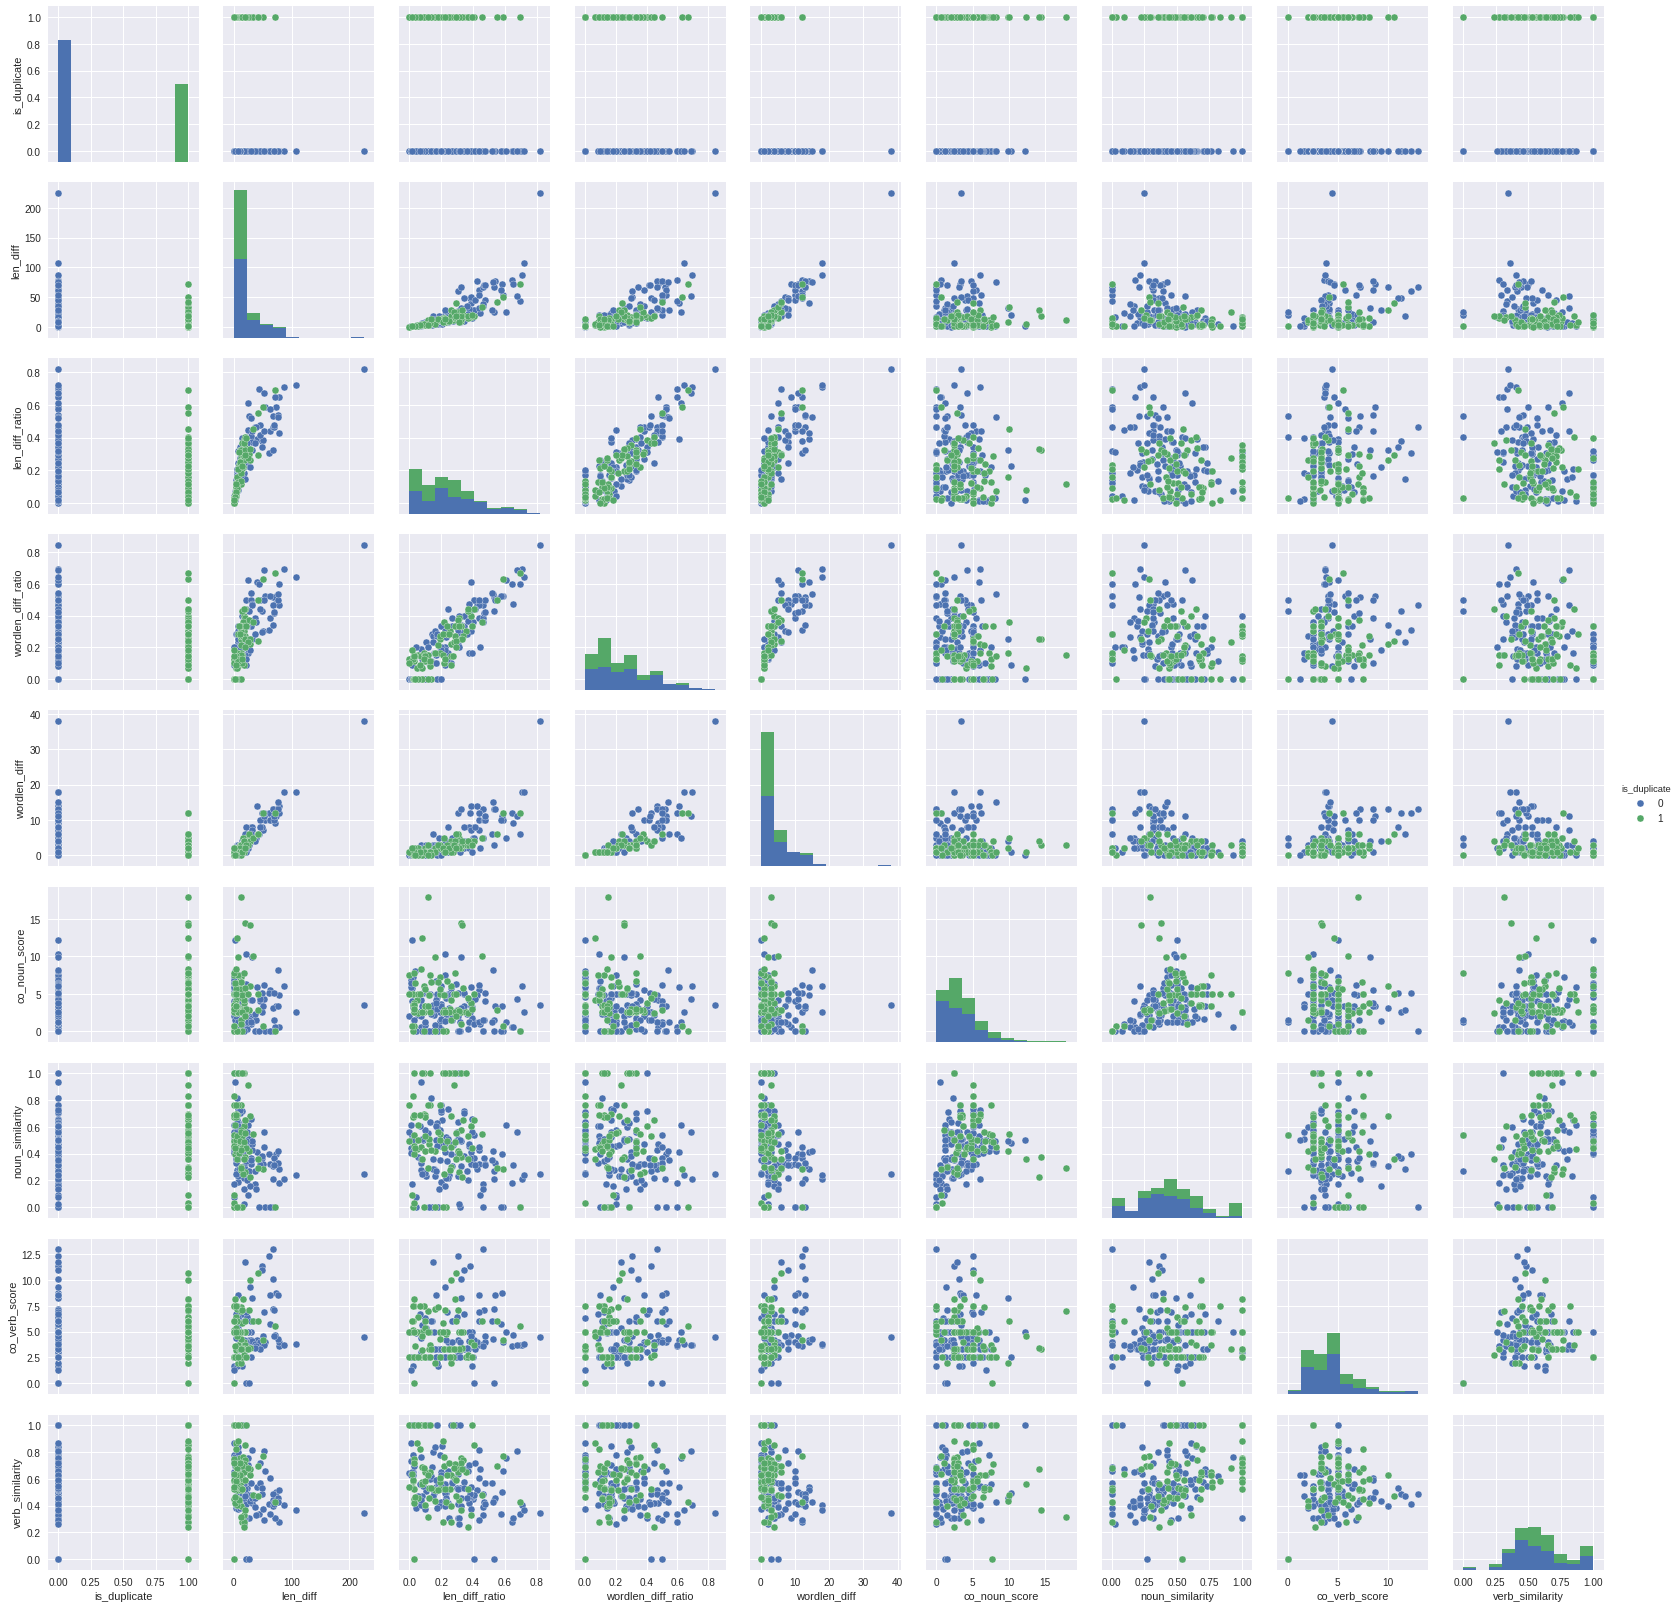

In [14]:
sns.pairplot(df.drop(['id', 'qid1', 'qid2'], axis=1).sample(200), hue='is_duplicate')

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [101]:
model = Sequential()
model.add(Dense(512, input_dim=8, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
model.fit(X_train.values, pd.get_dummies(y_train).values, validation_data=(X_test.values, pd.get_dummies(y_test).values))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 9s - loss: 0.5382 - acc: 0.7140 - val_loss: 0.5833 - val_acc: 0.6954
Epoch 2/10
100000/100000 [==============================] - 9s - loss: 0.5358 - acc: 0.7137 - val_loss: 0.5790 - val_acc: 0.7018
Epoch 3/10
100000/100000 [==============================] - 9s - loss: 0.5351 - acc: 0.7175 - val_loss: 0.5783 - val_acc: 0.7014
Epoch 4/10
100000/100000 [==============================] - 9s - loss: 0.5368 - acc: 0.7174 - val_loss: 0.5727 - val_acc: 0.7033
Epoch 5/10
100000/100000 [==============================] - 9s - loss: 0.5353 - acc: 0.7170 - val_loss: 0.5772 - val_acc: 0.7010
Epoch 6/10
100000/100000 [==============================] - 9s - loss: 0.5346 - acc: 0.7171 - val_loss: 0.6037 - val_acc: 0.7040
Epoch 7/10
100000/100000 [==============================] - 9s - loss: 0.5342 - acc: 0.7179 - val_loss: 0.6021 - val_acc: 0.7049
Epoch 8/10
100000/100000 [====================

In [104]:
accuracy_score(y_test.values, model.predict_classes(X_test.values)), log_loss(y_test.values, model.predict_proba(X_test.values)[:, 1])

 9248/10000 [==========================>...] - ETA: 0s

(0.70150000000000001, 0.5778414664968835)